# Generating training datasets

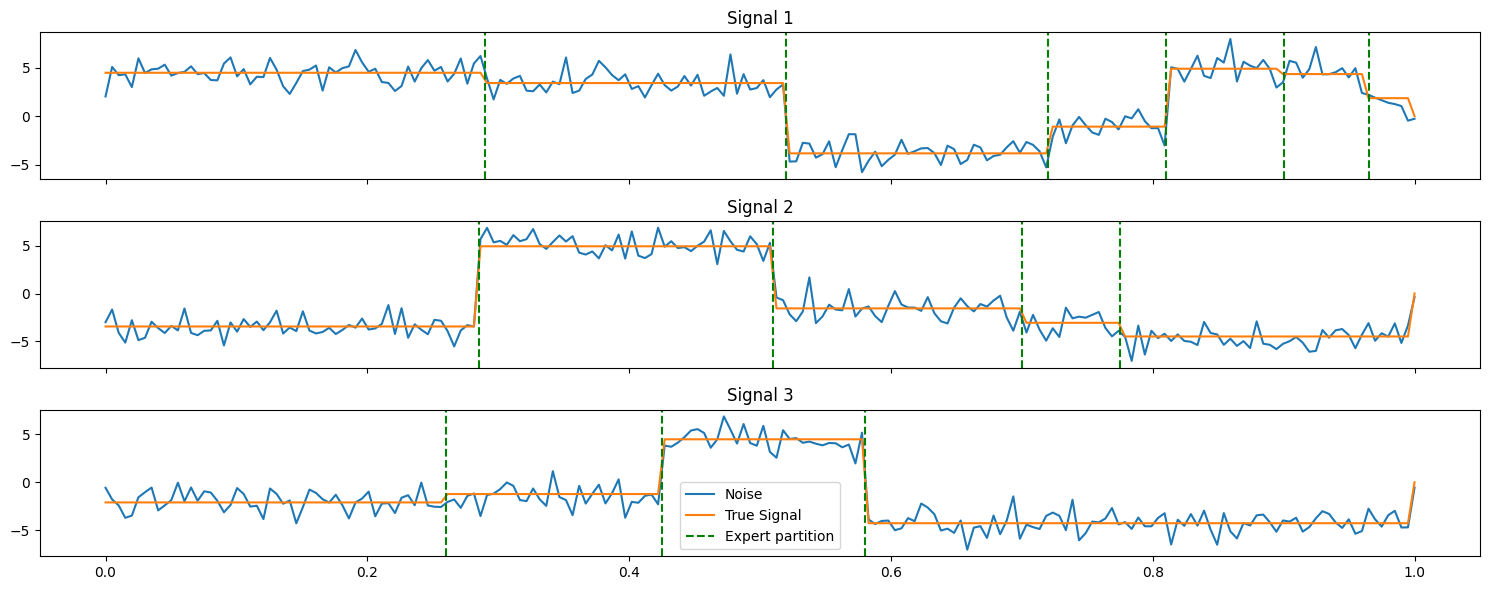

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_data(num_functions=100, n_points=100, sigma=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)

    true_functions = []
    noisy_functions = []
    true_partitions = []
    x = np.linspace(0, 1, n_points)

    for _ in range(num_functions):
        num_changepoints = np.random.randint(3, 8)
        regime_lengths = np.random.uniform(0.05, 0.3, size=num_changepoints)
        # Ensure the sum of regime lengths does not exceed the interval [0, 1]
        total_length = np.sum(regime_lengths)
        if total_length > 1:
            regime_lengths *= (1 / total_length)
        # Compute changepoints based on cumulative regime lengths
        changepoints = np.cumsum(regime_lengths).tolist()
        # Generate values for each regime
        values = np.random.uniform(1, 5, size=len(changepoints) + 1) * np.random.choice([-1, 1], len(changepoints) + 1)
        # Construct the piecewise constant function
        function = np.zeros_like(x)
        start_idx = 0
        for i, end_point in enumerate(changepoints + [1]):
            end_idx = np.searchsorted(x, end_point)
            function[start_idx:end_idx] = values[i]
            start_idx = end_idx
        # Add Gaussian noise
        noisy_function = function + np.random.normal(0, sigma, size=n_points)
        true_functions.append(function)
        noisy_functions.append(noisy_function)
        true_partitions.append(np.rint(np.array(changepoints) * n_points).astype(np.int32))

    return np.array(noisy_functions), true_partitions, true_functions


np.random.seed(42)
N = 100
n_points = 200
noise_variance = 1.0
signals, expert_partitions, true_signals = generate_synthetic_data(3, n_points, noise_variance)

def plot_signals(signals, true_signals, expert_partitions, changepoints=None):
  if changepoints:
    fig, axes = plt.subplots(len(signals), 2, figsize=(15, 6), sharex=True)
  else:
    fig, axes = plt.subplots(len(signals), 1, figsize=(15, 6), sharex=True)

  for i, ax in enumerate(axes):
    if changepoints:
      ax[0].plot(np.linspace(0, 1, n_points), signals[i], label='Noise')
      ax[0].plot(np.linspace(0, 1, n_points), true_signals[i], label='True Signal')

      ax[1].plot(np.linspace(0, 1, n_points), signals[i], label='Noise')
      ax[1].plot(np.linspace(0, 1, n_points), true_signals[i], label='True Signal')
    else:
      ax.plot(np.linspace(0, 1, n_points), signals[i], label='Noise')
      ax.plot(np.linspace(0, 1, n_points), true_signals[i], label='True Signal')

    for cp in expert_partitions[i]:
      if changepoints:
        ax[0].axvline(cp / n_points, color="green", linestyle="--", label="Expert partition")
      else:
        ax.axvline(cp / n_points, color="green", linestyle="--", label="Expert partition" if cp == expert_partitions[i][0] else None)

    if changepoints:
      for cp in changepoints[i]:
          ax[1].axvline(cp / n_points, color="red", linestyle="--")
    if changepoints:
      ax[0].set_title(f"Expert partition {i + 1}")
      ax[1].set_title(f"Predicted changepoints {i + 1}")
    else:
      ax.set_title(f"Signal {i + 1}")
  fig.tight_layout()
  plt.tight_layout()
  plt.legend()
  if changepoints:
    plt.savefig("predictions.pdf")
  else:
    plt.savefig("training_signals.pdf")
  plt.show()

plot_signals(signals, true_signals, expert_partitions)

# Linear time complexity algorithm for determining $\beta$-optimal partition(PELT)

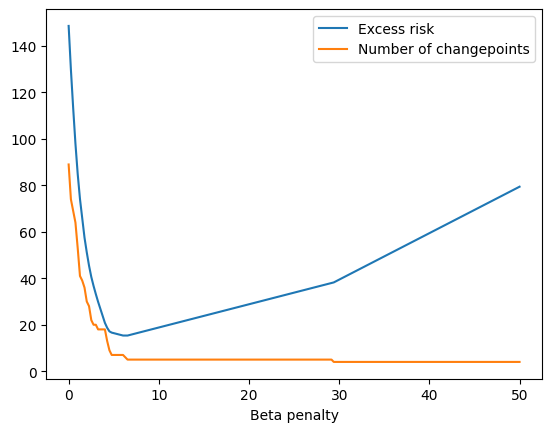

In [ ]:
def pelt(data, cost_func, penalty, min_size=1):
    n = len(data)
    F = np.zeros(n + 1)  # F[t]: Minimum cost for first t data points
    F[0] = -penalty  # Base case
    candidates = [0]  # Possible changepoint candidates
    backpointers = np.zeros(n, dtype=int)  # Stores the best previous changepoint

    for t in range(1, n + 1):
        # Evaluate the cost for each candidate
        costs = [F[tau] + cost_func(data, tau, t) + penalty for tau in candidates]
        F[t] = min(costs)  # Minimum cost
        backpointers[t - 1] = candidates[np.argmin(costs)]  # Best previous changepoint

        # Prune candidates
        candidates = [tau for tau in candidates if F[tau] + cost_func(data, tau, t) <= F[t]]
        candidates.append(t - min_size)  # Add the latest valid candidate

    # Backtrack to find changepoints
    changepoints = []
    t = n
    while t > 0:
        t = backpointers[t - 1]
        changepoints.append(t)
    changepoints = np.array(sorted(changepoints[:-1]))

    return changepoints

def mean_squared_error_cost(data, start, end):
    if start >= end:
      return 0

    segment = data[start:end]
    mean = np.mean(segment)
    cost = np.sum((segment - mean) ** 2)
    return cost

import numpy as np
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import directed_hausdorff

def hausdorff_metric(A, Alab, n_samples):

    if len(A) == 0 or len(Alab) == 0:
        return float('inf')
    h1 = directed_hausdorff(A[:, None], Alab[:, None])[0]
    h2 = directed_hausdorff(Alab[:, None], A[:, None])[0]
    return max(h1, h2) / n_samples

def precision_recall(A, Alab, tolerance=10):

    if len(A) == 0 or len(Alab) == 0:
        return 0.0, 0.0

    matched_A = np.zeros(len(A), dtype=bool)
    matched_Alab = np.zeros(len(Alab), dtype=bool)

    for i, a in enumerate(A):
        for j, alab in enumerate(Alab):
            if abs(a - alab) <= tolerance:
                matched_A[i] = True
                matched_Alab[j] = True

    precision = matched_A.sum() / len(A)
    recall = matched_Alab.sum() / len(Alab)

    return precision, recall

def annotation_error(A, Alab):

    return abs(len(A) - len(Alab))

def rand_index(A, Alab, n_samples):

    labels_A = np.zeros(n_samples, dtype=int)
    labels_Alab = np.zeros(n_samples, dtype=int)

    for i, cp in enumerate(np.sort(A)):
        labels_A[cp:] = i + 1

    for i, cp in enumerate(np.sort(Alab)):
        labels_Alab[cp:] = i + 1

    return adjusted_rand_score(labels_Alab, labels_A)

def excess_risk(y, A, A_lab, b):
    A_expert = np.concatenate([A_lab, [len(y)]])
    segments_lab = np.column_stack((np.roll(A_expert, 1), A_expert))
    segments_lab[0, 0] = 0

    optimal_cps = pelt(y, mean_squared_error_cost, b)
    optimal_cps = np.concatenate([optimal_cps, [len(y)]]).astype(np.int32)
    segments_opt = np.column_stack((np.roll(optimal_cps, 1), optimal_cps))
    segments_opt[0, 0] = 0

    R_b_lab = np.sum([mean_squared_error_cost(y, start, end) for start, end in segments_lab]) + b * len(segments_lab)
    R_b_opt = np.sum([mean_squared_error_cost(y, start, end) for start, end in segments_opt]) + b * len(segments_opt)

    return R_b_lab - R_b_opt


penalty = 5
results = []
hausdorffs = []
precision_recalls = []
annotation_errors = []
rand_indexs = []

def plot_excess_risk_over_beta(signal, expert_partition):
  excess_risk_array = []
  number_changepoints = []
  penalty_range = np.linspace(0, 50, 200)
  for p in penalty_range:
    changepoints = pelt(signals[0], mean_squared_error_cost, p)
    number_changepoints.append(len(changepoints))
    excess_risk_array.append(excess_risk(signal, changepoints, expert_partition, p))

  plt.plot(penalty_range, excess_risk_array, label='Excess risk')
  plt.plot(penalty_range, number_changepoints, label='Number of changepoints')
  plt.xlabel("Beta penalty")
  plt.legend()
  plt.savefig("excess_risk_vs_beta.pdf")
  plt.show()

plot_excess_risk_over_beta(signals[0], expert_partitions[0])
# plot_signals(signals, true_signals, expert_partitions, results)

# Final algorithm

In [ ]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar
import matplotlib.pyplot as plt

def excess_penalized_risk(y, A_lab, b):
    A_expert = np.concatenate([A_lab, [len(y)]])
    segments_lab = np.column_stack((np.roll(A_expert, 1), A_expert))
    segments_lab[0, 0] = 0

    optimal_cps = pelt(y, mean_squared_error_cost, b)
    optimal_cps = np.concatenate([optimal_cps, [len(y)]]).astype(np.int32)
    segments_opt = np.column_stack((np.roll(optimal_cps, 1), optimal_cps))
    segments_opt[0, 0] = 0

    R_b_lab = np.sum([mean_squared_error_cost(y, start, end) for start, end in segments_lab]) + b * len(segments_lab)
    R_b_opt = np.sum([mean_squared_error_cost(y, start, end) for start, end in segments_opt]) + b * len(segments_opt)

    return R_b_lab - R_b_opt

def optimize_penalty(signals, expert_partitions, max_iter=100):
    def average_excess_penalized_risk(b):
        risks = [excess_penalized_risk(y, A_lab, b[0]) for y, A_lab in zip(signals, expert_partitions)]
        return np.mean(risks)

    warm_start_signal = np.random.randint(len(signals), size=1)[0]
    y, A_lab = signals[warm_start_signal], expert_partitions[warm_start_signal]
    result = minimize_scalar(lambda b: excess_penalized_risk(y, A_lab, b), bounds=(0.1, 10), method="bounded")
    initial_guess = result.x

    result = minimize(
        average_excess_penalized_risk,
        x0=[initial_guess],
        bounds=[(0.1, 10)],
        method="L-BFGS-B",
        options={"maxiter": max_iter},
    )

    return result.x

b_opt = optimize_penalty(signals, expert_partitions)[0]
print(f"Optimal Penalty (b_opt): {b_opt}")

Optimal Penalty (b_opt): 6.977547368231786


[ 56  77  93 198] [ 56  77  93 113]
85.0
(0.75, 0.75)
0
0.7888894071520092

[ 24  40  62 143 155 176 197] [ 24  39  62 114 155 176]
29.0
(0.7142857142857143, 0.8333333333333334)
1
0.6841177764067651

[ 16  37  87 120 137 198] [ 12  37  87 120 138]
60.0
(0.8333333333333334, 1.0)
1
0.9495283629770334



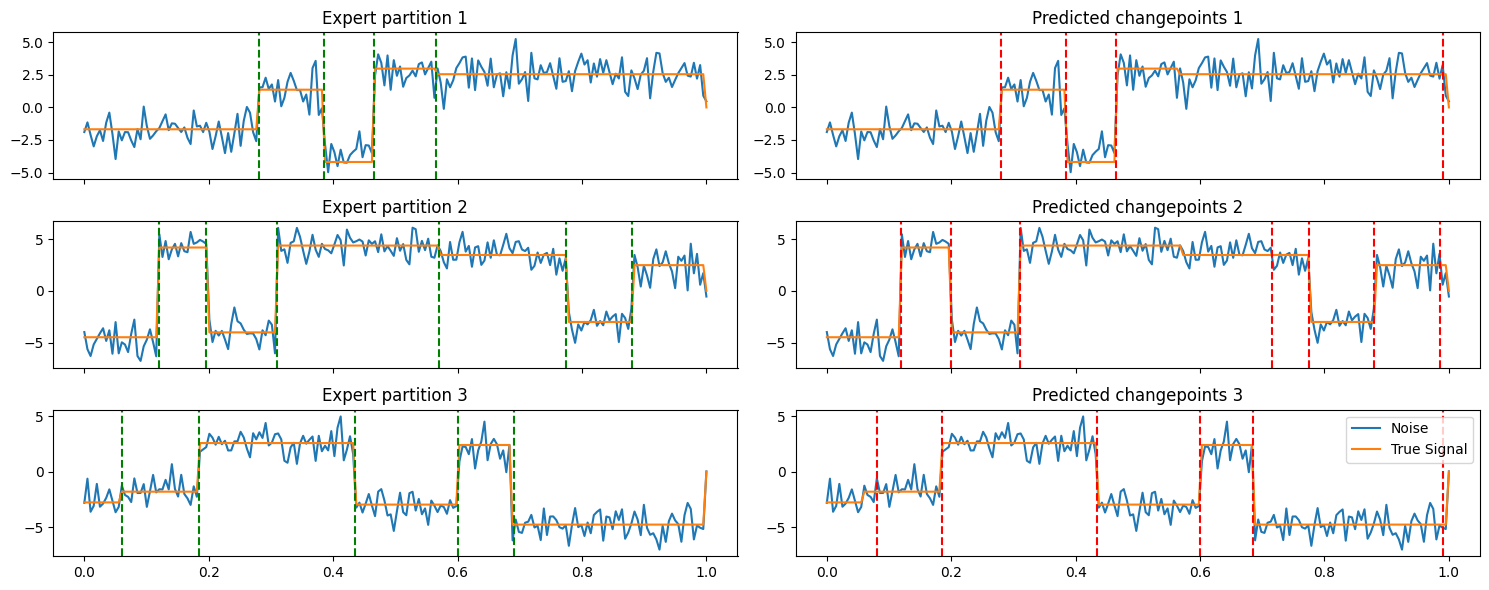

In [ ]:
test_signals, test_expert_partitions, test_true_signals = generate_synthetic_data(3, n_points, noise_variance)
test_changepoints = []
for i in range(len(test_signals)):
  change_points = pelt(test_signals[i], mean_squared_error_cost, b_opt)
  print(change_points, test_expert_partitions[i])
  print(hausdorff_metric(change_points, test_expert_partitions[i], len(test_signals[i])))
  print(precision_recall(change_points, test_expert_partitions[i]))
  print(annotation_error(change_points, test_expert_partitions[i]))
  print(rand_index(change_points, test_expert_partitions[i], len(test_signals[i])))
  print()
  test_changepoints.append(change_points)

plot_signals(test_signals, test_true_signals, test_expert_partitions, test_changepoints)